Решение задачи классификации с помощью нейронной сети (без использования фреймворков)

In [ ]:
import numpy as np
 
from sklearn.metrics import classification_report
 
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
 
import matplotlib.pyplot as plt
 
from tqdm import tqdm
 
from sklearn.metrics import accuracy_score
 
import time

Загружаем данные

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
 
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)
 
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
 
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
 
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()
 
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Определим функции активации (сигмоида и гиперболический тангенс) и их производные, функцию потерь и ее производную.

In [ ]:
 
def sigmoid(x): 
    return (1 / (1 + np.exp(-x)))
 
def d_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
 
def d_tanh(x):
    return 1-np.tanh(x)*np.tanh(x)
 
def calc_error(prediction, y):
    return - y*np.log(prediction) - (1-y)*(np.log(1-prediction))
    
def d_calc_error(prediction, y):
    return - (y-1)(1-prediction)-(y/prediction)
               

In [ ]:
learning_rate = 0.001
epochs = 50
 
n_features = 784
n_neurons1 = 150
 
w1 = np.random.rand(n_features, n_neurons1)/np.sqrt(n_features)
b1 = np.zeros(n_neurons1)
w2 = np.random.rand(n_neurons1, 1)/np.sqrt(n_features)
b2 = np.zeros(1)
 
losses = []
 
 
for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    
    for x, y in train_loader:
        batch_size = y.shape[0]
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        #прямое распространение
        z1 = x.dot(w1) + b1 
        a1 = np.tanh(z1)
        z2 = a1.dot(w2) + b2
        pred = sigmoid(z2)
        
        #Вычисление функции потерь для батча
        errors = calc_error(pred, y)
        bce = np.mean(errors)
        losses.append(bce)
      
        #Обратное распространение
        dloss_dpred = (-y/pred - (y-1)/(1-pred)) / x.shape[0]
   
        dpred_dz2 = d_sigmoid(z2)
        dloss_dz2 = dloss_dpred * dpred_dz2
        
 
        dloss_dw2 = np.dot(a1.T, dloss_dz2)
        dloss_db2 =  np.dot(np.ones((1, a1.shape[0])), dloss_dz2)[0]
 
        da1_dz1 = np.array([d_tanh(i) for i in z1])
       
        dz2_da1 = d_tanh(z2)
        dloss_dz1 = dloss_dz2 * dz2_da1
        
        dloss_dw1 = np.dot(x.T, dloss_dz1)
        dloss_db1 = np.dot(np.ones(x.shape[0]).T, dloss_dz1)
 
        #Обновление весов
        w2 -= learning_rate * dloss_dw2 
        w1 -= learning_rate * dloss_dw1
        b1 -= learning_rate * dloss_db1
        b2 -= learning_rate * dloss_db2

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


Построим график зависимости функции потерь (на тренировочных данных) от времени обучения

Text(0, 0.5, 'Loss function')

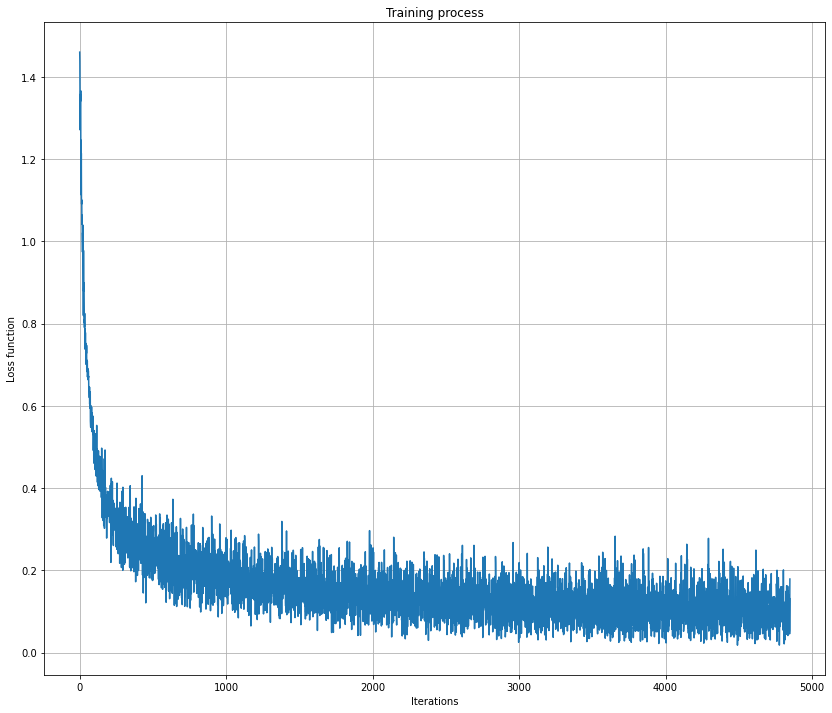

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

In [ ]:
np.mean(losses[-1000:])

0.10291538579209883